In [41]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
import random
from scipy import stats
from scipy.stats import norm
from scipy.special import comb
from scipy.stats import ecdf
from scipy.stats import t
from tqdm import tqdm
import time
import seaborn as sns
from sklearn.linear_model import LinearRegression

# Deel 1: Productieproces

## I. Voorbereiden van data voor model

### a. Importeren van de data 

In [42]:
BRU_loc = "/Users/gillesservais/Documents/Syntra/Project3/Opdracht - statistiek - visualizatie/data_productie/daily_production/BRU"
STO_loc = "/Users/gillesservais/Documents/Syntra/Project3/Opdracht - statistiek - visualizatie/data_productie/daily_production/STO"

def read_json(folder):

    dfs = []

    # Iterate over the files in the BRU location
    for file in os.listdir(folder):
        file_path = os.path.join(folder, file)
        if file.endswith('.json'):  # Check if the file is a JSON file
            try:
                df = pd.read_json(file_path, orient="index").transpose()
                dfs.append(df)
            except Exception as e:
                print(f"Error reading file {file}: {e}")

    # Concatenate all DataFrames into a single DataFrame
    result_df = pd.concat(dfs, ignore_index=True)

    return result_df

#Read Json and create dataframes
BRU_df_origin = read_json(BRU_loc)
STO_df_origin = read_json(STO_loc)

display(BRU_df_origin)
display(STO_df_origin)

,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Tuesday,1,0,09-22-2020 00:00:00.0000,No,225,18,1019
1,Monday,1,0,01-22-2018 00:00:00.0000,No,255,20,989
2,Wednesday,1,0,08-21-2019 00:00:00.0000,No,138,11,1106
3,Tuesday,1,0,08-21-2018 00:00:00.0000,No,302,24,942
4,Wednesday,1,0,09-22-2021 00:00:00.0000,No,211,17,1033
...,...,...,...,...,...,...,...,...
1825,Friday,1,0,07-29-2022 00:00:00.0000,No,157,13,1087
1826,Monday,1,0,07-20-2020 00:00:00.0000,No,289,23,955
1827,Sunday,1,0,06-23-2019 00:00:00.0000,No,140,11,1104
1828,Saturday,1,0,06-23-2018 00:00:00.0000,No,204,16,1040


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
0,Tuesday,1,0,09-22-2020 00:00:00.0000,No,85,31,189
1,Monday,1,0,01-22-2018 00:00:00.0000,No,51,19,223
2,Wednesday,1,0,08-21-2019 00:00:00.0000,No,110,40,164
3,Tuesday,1,0,08-21-2018 00:00:00.0000,Yes,#MV,#MV,#MV
4,Wednesday,1,0,09-22-2021 00:00:00.0000,No,134,49,140
...,...,...,...,...,...,...,...,...
1825,Friday,1,0,07-29-2022 00:00:00.0000,No,274,100,0
1826,Monday,1,0,07-20-2020 00:00:00.0000,No,81,29,193
1827,Sunday,1,0,06-23-2019 00:00:00.0000,No,72,26,202
1828,Saturday,1,0,06-23-2018 00:00:00.0000,No,77,28,197


### b. Onderzoeken en cleanen van de data

In [43]:
#Define data frame to continue with
BRU_df = BRU_df_origin.copy()

#check dtype of production
column_datatype = BRU_df['production'].dtype
print("Datatype of column production:", column_datatype)

#Check for double dates
prd = BRU_df.groupby("date").count()
display(prd[prd["production"] > 1])

#Check columns with #MV or 0 or NaN
display(BRU_df[(BRU_df['production'] == 0) | (BRU_df['production'].isna()) | (BRU_df['production'] == '#MV') ])
column_datatype = BRU_df['production'].dtype
print("Datatype of column production:", column_datatype)

#convert column to numbers and check dtype
BRU_df['production'] = pd.to_numeric(BRU_df['production'], errors='coerce').fillna(0)
display(BRU_df[(BRU_df['production'] == 0) | (BRU_df['production'].isna()) | (BRU_df['production'] == '#MV') ])
column_datatype = BRU_df['production'].dtype
print("Datatype of column:", column_datatype)

#Convert date column to date object
BRU_df['date'] = pd.to_datetime(BRU_df['date'])

#Order the date columns to plot in correct order 
BRU_df.sort_values(by='date', inplace=True)

Datatype of column production: object


,DoW,hour,minute,maintenance,prod_loss,prod_loss_perc,production
date,,,,,,,


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
6,Wednesday,1,0,12-26-2018 00:00:00.0000,No,1244,100,0
10,Tuesday,1,0,06-14-2022 00:00:00.0000,No,1244,100,0
11,Sunday,1,0,03-08-2020 00:00:00.0000,No,1244,100,0
16,Friday,1,0,05-25-2018 00:00:00.0000,No,1244,100,0
19,Wednesday,1,0,07-06-2022 00:00:00.0000,No,1244,100,0
...,...,...,...,...,...,...,...,...
1802,Thursday,1,0,05-12-2022 00:00:00.0000,Yes,#MV,#MV,#MV
1804,Sunday,1,0,12-09-2018 00:00:00.0000,No,1244,100,0
1805,Thursday,1,0,04-18-2019 00:00:00.0000,No,1244,100,0
1815,Saturday,1,0,02-24-2018 00:00:00.0000,No,1244,100,0


Datatype of column production: object


,DoW,hour,minute,date,maintenance,prod_loss,prod_loss_perc,production
6,Wednesday,1,0,12-26-2018 00:00:00.0000,No,1244,100,0.0
10,Tuesday,1,0,06-14-2022 00:00:00.0000,No,1244,100,0.0
11,Sunday,1,0,03-08-2020 00:00:00.0000,No,1244,100,0.0
16,Friday,1,0,05-25-2018 00:00:00.0000,No,1244,100,0.0
19,Wednesday,1,0,07-06-2022 00:00:00.0000,No,1244,100,0.0
...,...,...,...,...,...,...,...,...
1802,Thursday,1,0,05-12-2022 00:00:00.0000,Yes,#MV,#MV,0.0
1804,Sunday,1,0,12-09-2018 00:00:00.0000,No,1244,100,0.0
1805,Thursday,1,0,04-18-2019 00:00:00.0000,No,1244,100,0.0
1815,Saturday,1,0,02-24-2018 00:00:00.0000,No,1244,100,0.0


Datatype of column: float64


In [44]:
# Define filtered dataframes
BRU_maintenance_yes = BRU_df[BRU_df['maintenance'] == 'Yes']
BRU_maintenance_no = BRU_df[BRU_df['maintenance'] == 'No']
BRU_prod = BRU_df[BRU_df["maintenance"] == "No"]
BRU_noprod = BRU_prod[BRU_prod['production']==0]
BRU_prodprod = BRU_df[BRU_df['production']!=0]

In [45]:
# Number of maintenance days per year
BRU_maintenance_yes.loc[:, "year"] = BRU_maintenance_yes['date'].dt.year.copy()
BRU_maintenance_yes.groupby("year").agg({'maintenance': 'count'})

/var/folders/wj/b_g3wk317r75th68qxlld3yr0000gn/T/ipykernel_80879/2550594858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  BRU_maintenance_yes.loc[:, "year"] = BRU_maintenance_yes['date'].dt.year.copy()


,maintenance
year,
2018,19
2019,18
2020,20
2021,19
2022,18


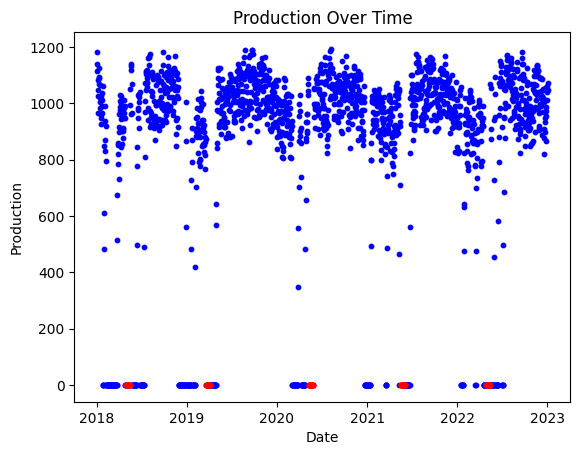

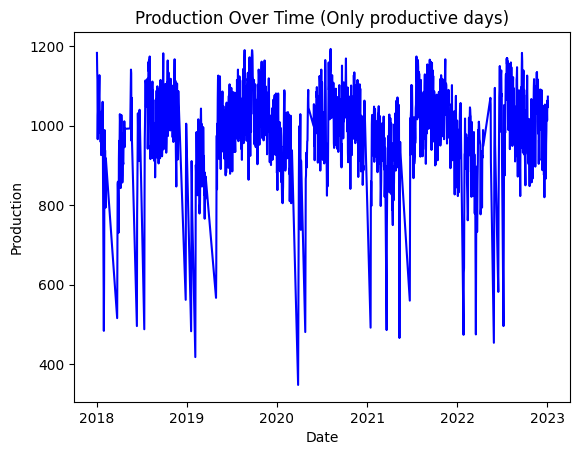

In [46]:
# Plot production over time 
plt.scatter(BRU_maintenance_no['date'], BRU_maintenance_no['production'], label='Maintenance No', color='blue', s=10)
plt.scatter(BRU_maintenance_yes['date'], BRU_maintenance_yes['production'], label='Maintenance Yes', color='red', s=10)
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Production Over Time')
plt.show()

# Plot production over time, no productive days excluded
plt.plot(BRU_prodprod['date'], BRU_prodprod['production'], color='blue' )
plt.xlabel('Date')
plt.ylabel('Production')
plt.title('Production Over Time (Only productive days)')
plt.show()

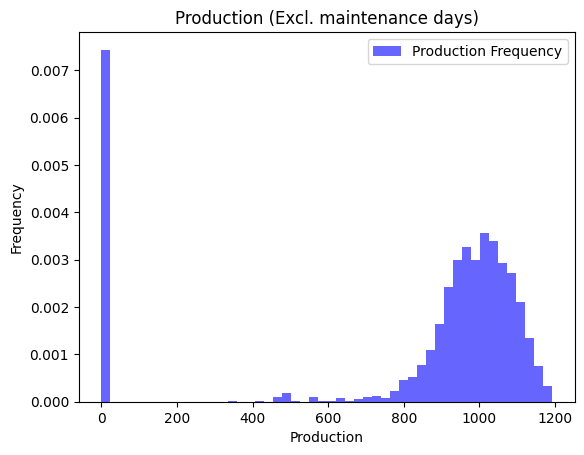

In [47]:
# Plot histogram of production data, excl maintenance days
plt.hist(BRU_prod['production'], bins=50, density=True, alpha=0.6, color='blue', label='Production Frequency')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.title('Production (Excl. maintenance days)')
plt.legend()
plt.show()

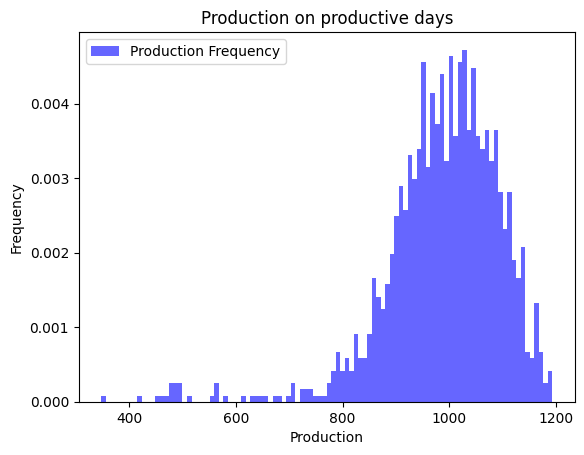

In [48]:
#Filter data frame to days with production
plt.hist(BRU_prodprod['production'], bins=100, density=True, alpha=0.6, color='blue', label='Production Frequency')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.title('Production on productive days')
plt.legend()
plt.show()

### c. Normality test

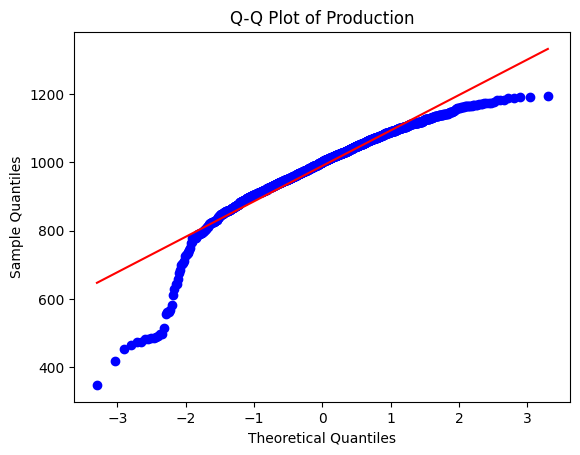

In [49]:
# Create the Q-Q plot
stats.probplot(BRU_prodprod['production'], dist='norm', plot=plt)
plt.title('Q-Q Plot of Production')
plt.xlabel('Theoretical Quantiles')
plt.ylabel('Sample Quantiles')
plt.show()

In [50]:
# Perform Shapiro-Wilk test for normality
shapiro_stat, shapiro_p_value = stats.shapiro(BRU_prodprod['production'])
print(f'Shapiro-Wilk test statistic: {shapiro_stat}')
print(f'p-value: {shapiro_p_value}')

Shapiro-Wilk test statistic: 0.9048126212094065
p-value: 6.211531009189913e-29


<u>Conclusion:</u> the data is not normally distributed. However, we will make the assumption that it still is normally distributed.

## II. Define Model
### a. General model: productive and non productive days

In [51]:
# Group by production or no production
BRU_prod_agg = BRU_prod.groupby(lambda x: 'No production' if BRU_prod.loc[x, 'production'] == 0 else 'Production').agg({'production': ['count', 'mean','std']})

# Add calculated column with probability
total_count = BRU_prod_agg['production', 'count'].sum()
BRU_prod_agg['probability'] = BRU_prod_agg['production', 'count'] / total_count
display(BRU_prod_agg)

P_prod = BRU_prod_agg.loc['Production','probability'].iloc[0]
P_noprod = BRU_prod_agg.loc['No production','probability'].iloc[0]

production                         probability
                   count        mean         std            
No production        308    0.000000    0.000000    0.177419
Production          1428  989.218487  108.946056    0.822581

### b. Create model: One day - normal distribution

Mean: 989.218487394958
Standard deviation: 108.90790262811456


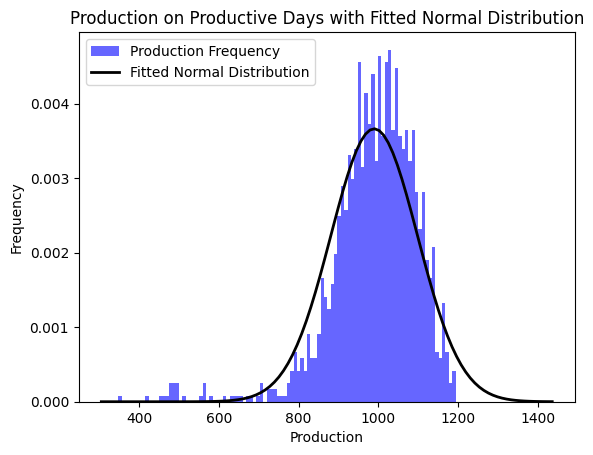

In [52]:
#Define data for model
data = BRU_prodprod["production"]

#Define a class for the model
class Model:
    def __init__(self, data):
        self.data = data
        self.mu = None
        self.sigma = None
        self.fit_normal_distribution()

    def fit_normal_distribution(self):
        self.mu, self.sigma = norm.fit(self.data)

    def parameters(self):
        print("Mean:", self.mu)
        print("Standard deviation:", self.sigma)

    def fitmodel(self):
        # Plot histogram of production data
        plt.hist(self.data, bins=100, density=True, alpha=0.6, color='blue', label='Production Frequency')

        # Create range for x values
        xmin, xmax = plt.xlim()
        x = np.linspace(xmin, xmax+200, 100)

        # Create PDF for fitted normal distribution
        p = norm.pdf(x, self.mu, self.sigma)

        # Plot the PDF
        plt.plot(x, p, 'k', linewidth=2, label='Fitted Normal Distribution')

        # Add labels and legend
        plt.xlabel('Production')
        plt.ylabel('Frequency')
        plt.title('Production on Productive Days with Fitted Normal Distribution')
        plt.legend()

        # Show plot
        plt.show()

#Create an object that holds the model parameters
BRU_model = Model(data)
#Print the model attributes
BRU_model.parameters()
#Fit model
BRU_model.fitmodel()

### c. Multi day: Mathemathical model

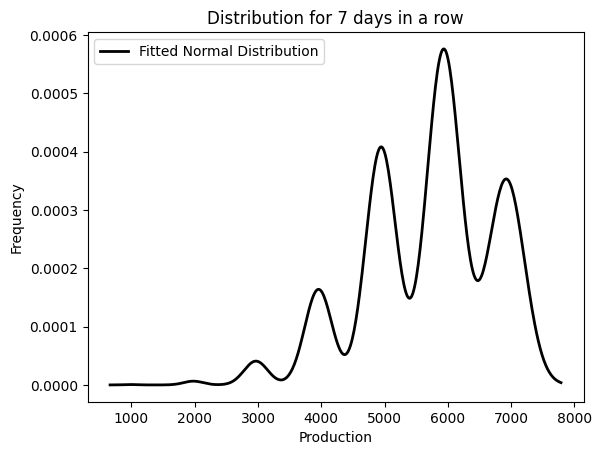

In [53]:
#Parameters of model
days = 7
model = BRU_model
probability_prod = P_prod


def Model_multiday(days, model, probability_prod):
    #Create empty distribution
    p_days = 0

    #Probability for k days of production
    p = probability_prod
    x = np.linspace(model.mu - 3*model.sigma, days*model.mu + 3*model.sigma*np.sqrt(days), 500)
    probabilities_per_day = [comb(days, k) * (p ** k) * ((1 - p) ** (days - k)) for k in range(1, days + 1)]

    #Convolution of multiple days
    for i in range(days):
        day = i+1
        p = norm.pdf(x, (model.mu)*day, (model.sigma)*np.sqrt(day)) * probabilities_per_day[i]
        p_days = p_days + p

    return x, p_days

x, p_days = Model_multiday(days, BRU_model, probability_prod)

#Superpositie of all cases
plt.plot(x, p_days, 'k', linewidth=2, label='Fitted Normal Distribution')
plt.xlabel('Production')
plt.ylabel('Frequency')
plt.title(f'Distribution for {days} days in a row')
plt.legend() 
plt.show()

### d. Multi day: Monte Carlo simulation

Text(0.5, 1.0, 'Distribution for 7 days in a row')

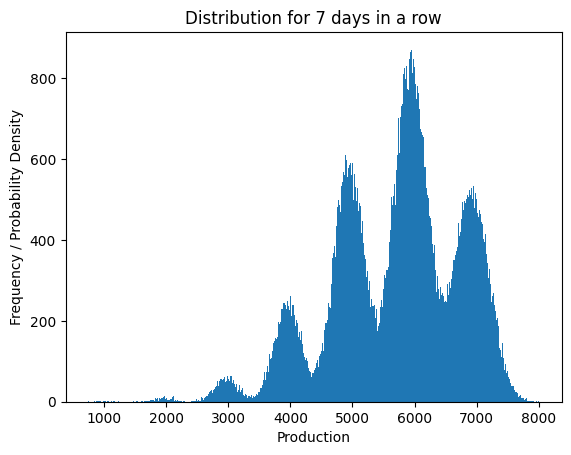

In [54]:
# Parameters of model
days = 7
runs = 100000
model = BRU_model
probability_prod= P_prod 

# Monte Carlo-simulatie
def Simulation_multiday(days, runs, model, probability_prod):
    prod_days = []
    #Simulate runs
    for i in range(runs):
        prod_sum = 0
        #Production for consecutive days
        for n in range(days):
            if random.random() < probability_prod:
                prod = np.random.normal(model.mu, model.sigma)
                prod_sum += prod
            else:
                prod_sum = prod_sum
        prod_days.append(prod_sum)

    return prod_days

P = Simulation_multiday(days, runs, model, probability_prod)
plt.hist(P, 500)
# Set labels and title
plt.xlabel('Production')
plt.ylabel('Frequency / Probability Density')
plt.title(f'Distribution for {days} days in a row')

### e. Empirische Commulatieve Distributiefunctie

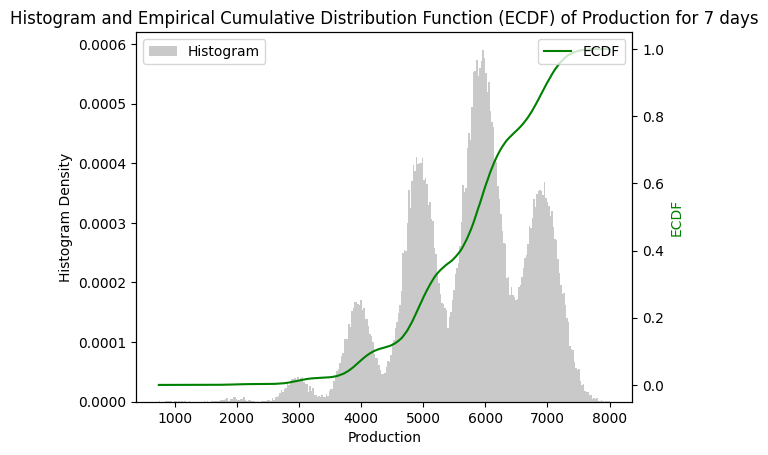

In [55]:
from scipy.stats import ecdf
import matplotlib.pyplot as plt

# Compute ECDF
ecdf_result = ecdf(P)

# Create figure and axis objects
fig, ax1 = plt.subplots()

# Plot histogram on primary y-axis
ax1.hist(P, bins=300, color=(0.7, 0.7, 0.7, 0.5), alpha=0.7, density=True, label='Histogram')
ax1.set_xlabel('Production')
ax1.set_ylabel('Histogram Density')

# Create a secondary y-axis for ECDF
ax2 = ax1.twinx()

# Plot ECDF on secondary y-axis
ax2.plot(ecdf_result.cdf.quantiles, ecdf_result.cdf.probabilities, label='ECDF', color='green', marker='', linestyle='-')
ax2.set_ylabel('ECDF', color='green')

# Set title and legend
plt.title(f'Histogram and Empirical Cumulative Distribution Function (ECDF) of Production for {days} days')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

## III. Spelen met modellen

### a. Performance: A comparison of simulation and mathematical model

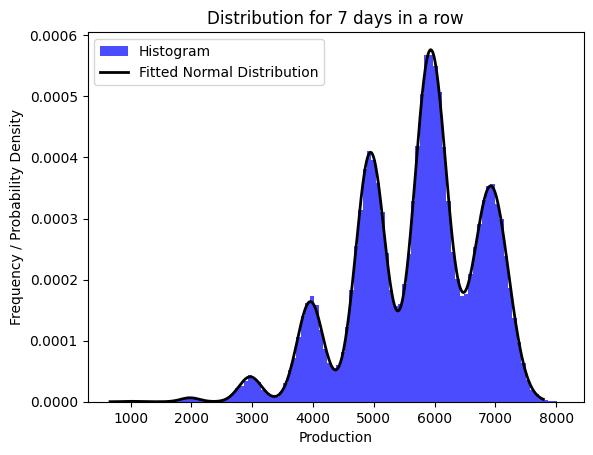

Time Mathematical model: 0.27739596366882324 
Time Simulation model: 0.0004589557647705078


In [56]:
# Parameters of model
days = 7
model = BRU_model
probability_prod= P_prod 

#Record time needed for simulation model
start_time_simulation = time.time()
P = Simulation_multiday(days, runs, model, probability_prod)
end_time_simulation = time.time()
total_time_mathematical = end_time_simulation - start_time_simulation

#Record time for mathematical model
start_time_simulation = time.time()
x, p_days = Model_multiday(days, BRU_model, P_prod)
end_time_simulation = time.time()
total_time_simulation = end_time_simulation - start_time_simulation

# Plot histogram with density parameter
plt.hist(P, bins=100, color='blue', alpha=0.7, density=True, label='Histogram')

# Plot fitted normal distribution
plt.plot(x, p_days, 'k', linewidth=2, label='Fitted Normal Distribution')

# Set labels and title
plt.xlabel('Production')
plt.ylabel('Frequency / Probability Density')
plt.title(f'Distribution for {days} days in a row')

# Show legend
plt.legend()

# Show the plot
plt.show()

print(f"Time Mathematical model: {total_time_mathematical} \nTime Simulation model: {total_time_simulation}")

<u>Conclusion:</u> By running both models for the same parameters we can conclude that the simulation model (Monte-Carlo) will provide better performance compared to the Mathematical model. This is probably due to the increading complexity of convolution.

### b. Vergelijken met centrale limietstelling

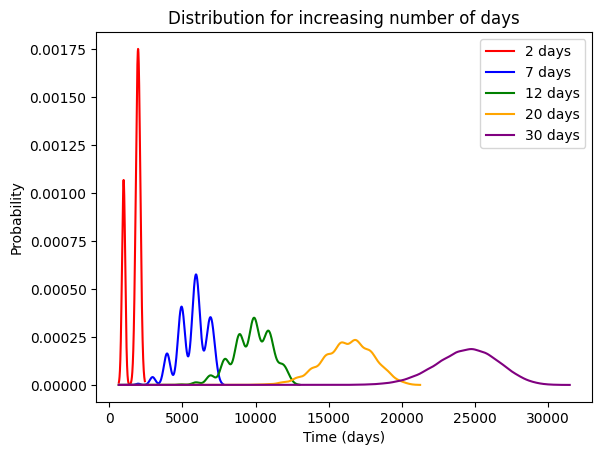

In [57]:
# Parameters of model
model = BRU_model
probability_prod= P_prod 

#Model for 7 days
x1, p1_days = Model_multiday(2, BRU_model, probability_prod)

#Model for 15 days
x2, p2_days = Model_multiday(7, BRU_model, probability_prod)

#Model for 30 days
x3, p3_days = Model_multiday(12, BRU_model, probability_prod)

#Model for 50 days
x4, p4_days = Model_multiday(20, BRU_model, probability_prod)

#Model for 100 days
x5, p5_days = Model_multiday(30, BRU_model, probability_prod)


# Plot the data for each model on the same graph
plt.plot(x1, p1_days, label='2 days', color='red')
plt.plot(x2, p2_days, label='7 days', color='blue')
plt.plot(x3, p3_days, label='12 days', color='green')
plt.plot(x4, p4_days, label='20 days', color='orange')
plt.plot(x5, p5_days, label='30 days', color='purple')

# Add labels and title
plt.xlabel('Time (days)')
plt.ylabel('Probability')
plt.title('Distribution for increasing number of days')

# Add legend
plt.legend()

# Show plot
plt.show()

<u>Conclusie:</u> Bij toenemende n zal de distrubutie de vorm van een normaalverdeling aannemen. Dit geeft de Centrale Limietstelling weer. 

# Deel 2: Autproductie

### Overzicht
We kijken naar de dataset `cars.csv`, deze bevat informatie over de verkoop van 2e hands Volvo’s. We hebben hier een aantal vragen over, beantwoord deze vragen door een beetje code te schrijven en de antwoorden op te schrijven in een Jupyter Notebook.

In [58]:
#Read data and show preview
cars_csv = "/Users/gillesservais/Documents/Syntra/Project3/Opdracht - statistiek - visualizatie/cars.csv"
cars_data = pd.read_csv(cars_csv)
cars_data.head()

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
0,Acura,ILX Hybrid 1.5L,2013,92945.0,"1.5L I-4 i-VTEC variable valve control, engine...",Automatic,Front-wheel Drive,Gasoline,39-38,Black,Parchment,0.0,0.0,0.0,Iconic Coach,NaN,4.4,12.0,300.0,13988.0
1,Acura,ILX Hybrid 1.5L,2013,47645.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Gray,Ebony,1.0,1.0,1.0,Kars Today,NaN,4.4,12.0,NaN,17995.0
2,Acura,ILX Hybrid 1.5L,2013,53422.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Bellanova White Pearl,Ebony,0.0,1.0,1.0,Weiss Toyota of South County,4.3,4.4,12.0,500.0,17000.0
3,Acura,ILX Hybrid 1.5L,2013,117598.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,Polished Metal Metallic,NaN,0.0,1.0,1.0,Apple Tree Acura,NaN,4.4,12.0,675.0,14958.0
4,Acura,ILX Hybrid 1.5L,2013,114865.0,1.5L I4 8V MPFI SOHC Hybrid,Automatic CVT,Front-wheel Drive,Hybrid,39-38,NaN,Ebony,1.0,0.0,1.0,Herb Connolly Chevrolet,3.7,4.4,12.0,300.0,14498.0


### Vraag 1:
Wat voor soort data zijn `year`, `fuel_type` en `seller_rating`? Motiveer je antwoord.

In [59]:
#Filter to specific columns
cars_selected = cars_data.loc[:, ['year', 'fuel_type', 'seller_rating']]

# Display the selected columns
display(cars_selected)

# Check the data types of the selected columns
print(cars_selected.dtypes)

,year,fuel_type,seller_rating
0,2013,Gasoline,NaN
1,2013,Hybrid,NaN
2,2013,Hybrid,4.3
3,2013,Hybrid,NaN
4,2013,Hybrid,3.7
...,...,...,...
762086,2022,Gasoline,4.2
762087,2012,Gasoline,NaN
762088,2014,Gasoline,NaN
762089,2013,Gasoline,4.6


year               int64
fuel_type         object
seller_rating    float64
dtype: object


**"year":** kwantitatief discrete data. In python voorgesteld door een 64 bit integer getal.  

**"fuel_type":** kwalitatief (categorische) nominale data. Momenteel voorgesteld als een object in Python. Alhoewel omzetten naar datatype "category" zou zorgen voor efficiëntere opslag in Python.  

**"seller_rating":** kwalitatief discrete of continue data. Als er een beperkt aantal ratings mogelijk zijn spreken we van discrete data. In Python voorgesteld als een 64 bit float getal (continue data).  


### Vraag 2:
Ik vraag me af hoe een gewoonlijke (mbt prijs) $2^e$ hands Volvo eruit ziet. Kan je deze zoeken en tonen?

In [60]:
#Filter to Volvo cars
volvo_cars = cars_data.loc[cars_data['manufacturer'] == 'Volvo']
display(volvo_cars.head())

gewoonlijke_cars = volvo_cars.loc[volvo_cars.apply(lambda row: row.astype(str).str.contains('gewoonlijke').any(), axis=1)]
display(gewoonlijke_cars)

,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price
752062,Volvo,XC90 Recharge Plug-In Hybrid T8 Inscription 6 ...,2022,10363.0,2.0L I4 16V GDI DOHC Hybrid,8-Speed Automatic,All-wheel Drive,Hybrid,NaN,Crystal White Metallic,Blond,0.0,0.0,1.0,Volvo Cars Arrowhead,2.9,NaN,0.0,4500.0,67998.0
752063,Volvo,XC90 Recharge Plug-In Hybrid T8 Inscription Ex...,2021,30404.0,2.0L I4 16V GDI DOHC Hybrid,8-Speed Automatic,All-wheel Drive,Hybrid,NaN,Gray,Charcoal,0.0,1.0,1.0,Weston Nissan Volvo Cars,4.8,3.8,14.0,8000.0,49995.0
752064,Volvo,XC90 Recharge Plug-In Hybrid T8 EAWD PHEV INSC...,2022,5968.0,2.0L I4 16V GDI DOHC Hybrid,8-Speed Automatic,All-wheel Drive,Hybrid,NaN,Crystal White Metallic,Charcoal,0.0,1.0,0.0,"Volvo Cars Plymouth, A Premier Company",4.7,NaN,0.0,200.0,62700.0
752065,Volvo,XC90 Recharge Plug-In Hybrid T8 Inscription Ex...,2022,8732.0,2.0L I4 16V GDI DOHC Hybrid,8-Speed Automatic,All-wheel Drive,Hybrid,NaN,Blue,NaN,0.0,1.0,1.0,Karp Kia,3.9,NaN,0.0,1500.0,59500.0
752066,Volvo,XC90 Recharge Plug-In Hybrid T8 Inscription Ex...,2022,9607.0,2.0L I4 16V GDI DOHC Turbo Hybrid,8-Speed Automatic,All-wheel Drive,Hybrid,NaN,Denim Blue Metallic,Amber,0.0,1.0,1.0,LaFontaine Volvo Cars of Farmington Hills,2.8,NaN,0.0,1893.0,72652.0


,manufacturer,model,year,mileage,engine,transmission,drivetrain,fuel_type,mpg,exterior_color,interior_color,accidents_or_damage,one_owner,personal_use_only,seller_name,seller_rating,driver_rating,driver_reviews_num,price_drop,price


### Vraag 3:
We kunnen de verdeling van de prijs van $2^e$ hands Volvo's voorstellen met een histogram:
![alt text](image.png)
 - Waar zou je verwachten dat het gemiddelde +/- ligt voor deze verdeling?
 - Waar zou je verwachten dat de mediaan +/- ligt?

Teken dit histogram met `.hist` en gebruik `.axvline` om de mediaan en het gemiddelde toe te voegen aan de plot. Komt dit overeen met je verwachting?

 - Kan je de emprisiche cummulatieve distributie functie tekenen voor de verdeling die overeenkomt met dit histogram (zie ook `scipy.stats.ecdf`).

De hoogste prijs in de dataset is:, 1000000000.0. Dus we kappen af op 100 000


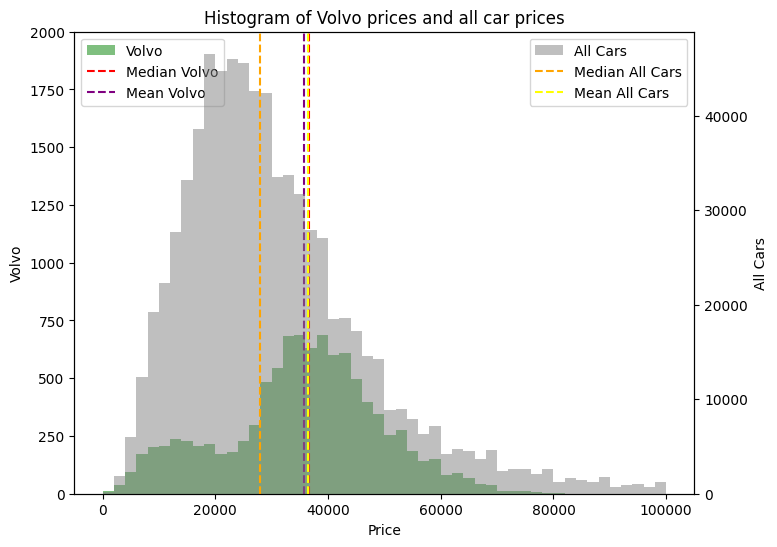

In [61]:
#Define price range
max_price = cars_data['price'].max()
print(f"De hoogste prijs in de dataset is:, {max_price}. Dus we kappen af op 100 000")

# Calculate the maximum price for all cars
max_price_all = 100000

# Make a new figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot histogram of Volvo prices with customized bins and range
ax1.hist(volvo_cars['price'], color='green', alpha=0.5, label='Volvo', bins=50, range=(0, max_price_all))
ax1.set_ylim(0, 2000) 
ax1.set_title('Histogram of Volvo prices and all car prices')
ax1.set_xlabel('Price')
ax1.set_ylabel('Volvo')

# Add a second y-axis for all car prices
ax2 = ax1.twinx()

# Plot histogram of all car prices with customized bins and range
ax2.hist(cars_data['price'], color='grey', alpha=0.5, label='All Cars', bins=50, range=(0, max_price_all))
ax2.set_ylabel('All Cars')

# Add vertical line for the median of Volvo prices
median_volvo = volvo_cars['price'].median()
ax1.axvline(x=median_volvo, color='red', linestyle='--', label='Median Volvo')

# Add vertical line for the mean of Volvo prices
mean_volvo = volvo_cars['price'].mean()
ax1.axvline(x=mean_volvo, color='purple', linestyle='--', label='Mean Volvo')

# Add vertical line for the median of all car prices
median_all = cars_data['price'].median()
ax2.axvline(x=median_all, color='orange', linestyle='--', label='Median All Cars')

# Add vertical line for the mean of all car prices
mean_all = cars_data['price'].mean()
ax2.axvline(x=mean_all, color='yellow', linestyle='--', label='Mean All Cars')

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

**Antwoord:** Moeilijk vooraf te zeggen waar gemiddelde en mediaan van Volvo auto's zich ten opzichte van elkaar bevinden. Mogelijke redenering: enkele uitschieters in tweedehands prijzen kunnen het gemiddelde sterk doen stijgen zodat het hoger ligt dan de mediaan. In de praktijk lijken gemiddelde en mediaan zeer dicht tegen elkaar te liggen. 

In vergelijking met gemiddelde en mediaan van alle merken ligt de mediaan prijs van Volvo auto's hoger. Dit is weinig verassend omdat Volvo in een luxueuser segment meespeelt. Verbazend is wel dat het gemiddelde van Volvo auto's overeen komt (net lager zelfs) met het gemiddelde van alle auto's. Dit komt omdat er een groep auto's is die een stuk duurder worden verkocht dan de volvo's en die de gemiddelde prijs sterk doet stijgen van de hele groep. 

Tot slot ECDF hieronder weergegeven.
 

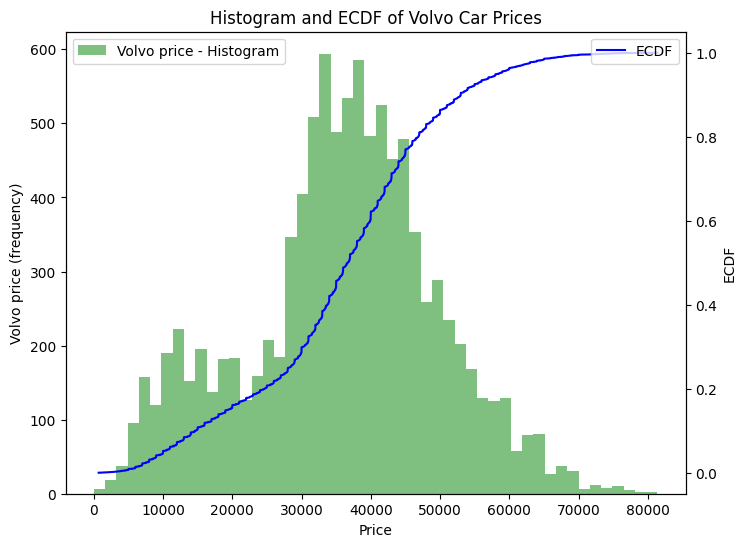

In [62]:

#Calculate max price of Volvo
max_price = volvo_cars['price'].max()

# Make a new figure
fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot histogram of Volvo prices
ax1.hist(volvo_cars['price'], color='green', alpha=0.5, label='Volvo price - Histogram', bins=50, range=(0, max_price))

# Set title and labels for the first y-axis
ax1.set_title('Histogram and ECDF of Volvo Car Prices')
ax1.set_xlabel('Price')
ax1.set_ylabel('Volvo price (frequency)')

# Create a second y-axis for ECDF
ax2 = ax1.twinx()

# Compute ECDF for Volvo prices
ecdf_result = ecdf(volvo_cars['price'])

# Plot ECDF on secondary y-axis
ax2.plot(ecdf_result.cdf.quantiles, ecdf_result.cdf.probabilities, label='ECDF', color='blue', marker='', linestyle='-')
ax2.set_ylabel('ECDF')

# Add legend
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Show the plot
plt.show()

### Vraag 4:
Ik wil nu de verschillende fuel types vergelijken hoeveel deze kosten. Hiervoor maak ik volgende afbeelding met meerdere histogrammen hoe kunnen we deze beter maken? Welke alternatieven zijn er nog?
![alt text](image-1.png)

**Antwoord:** Hieronder enkele alternatieven die overzichtelijker zijn:
- Barplot
- Stripplot
- Boxplot
- Violinplot


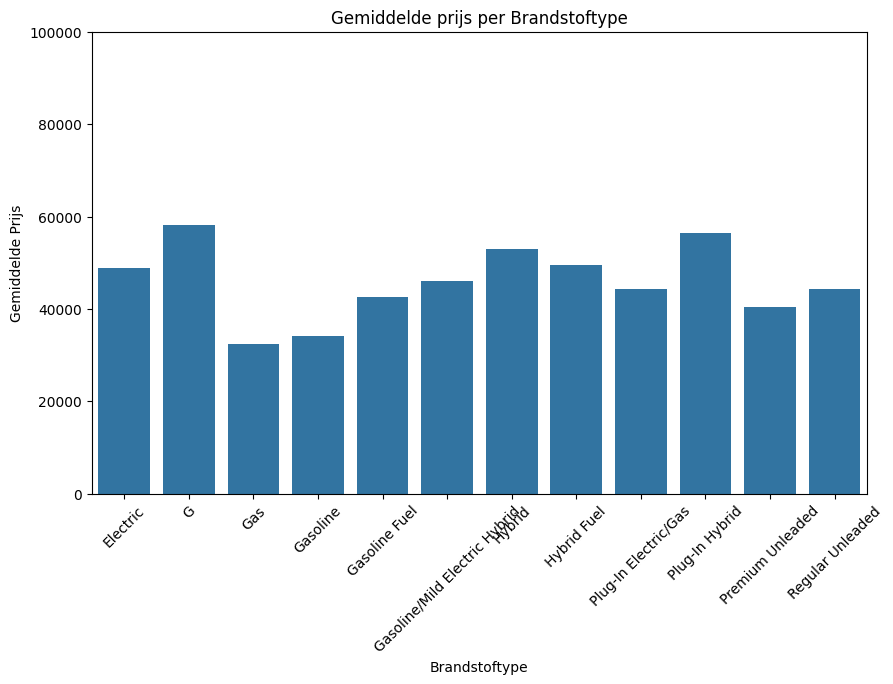

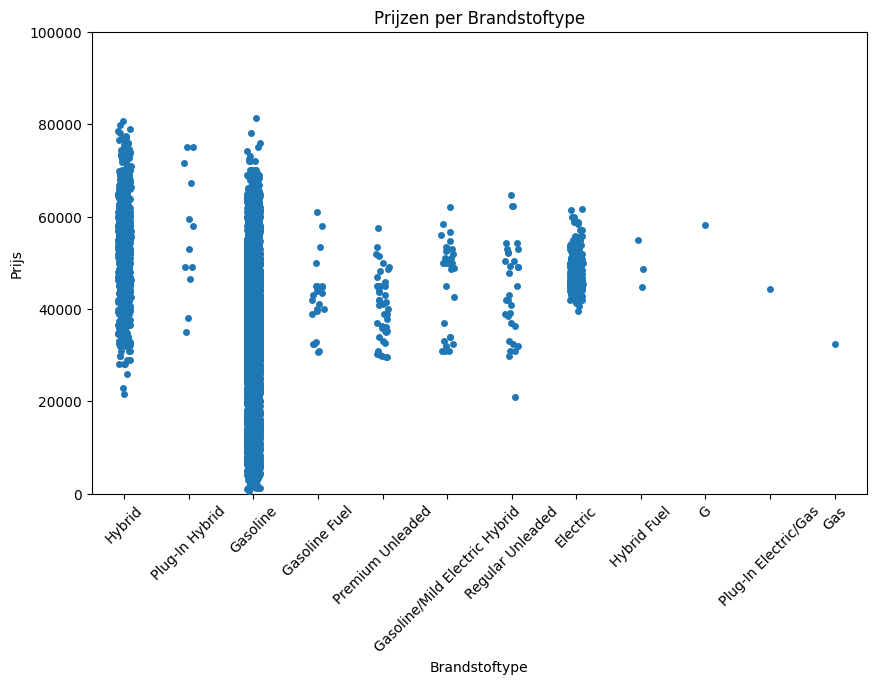

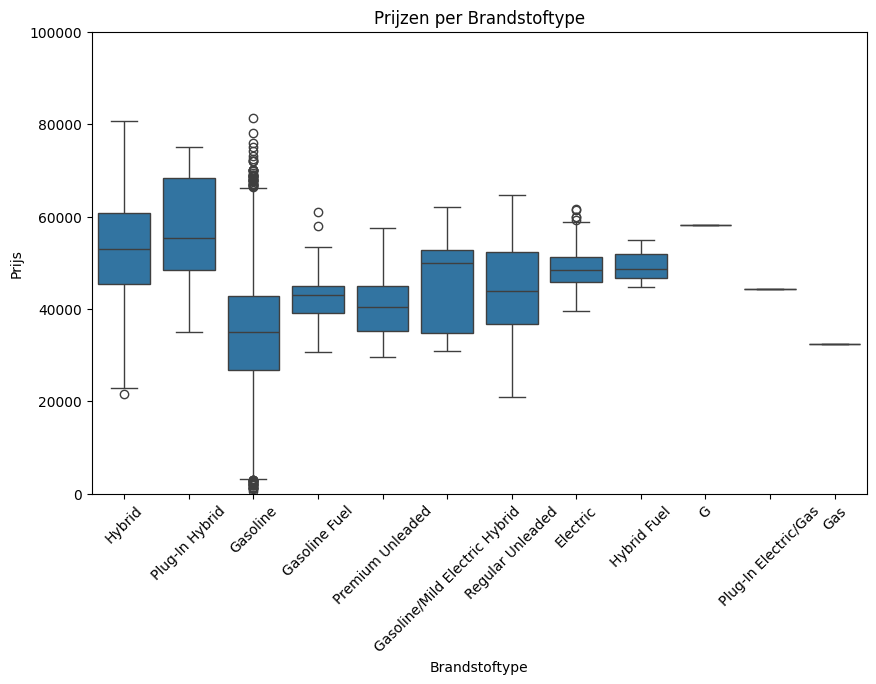

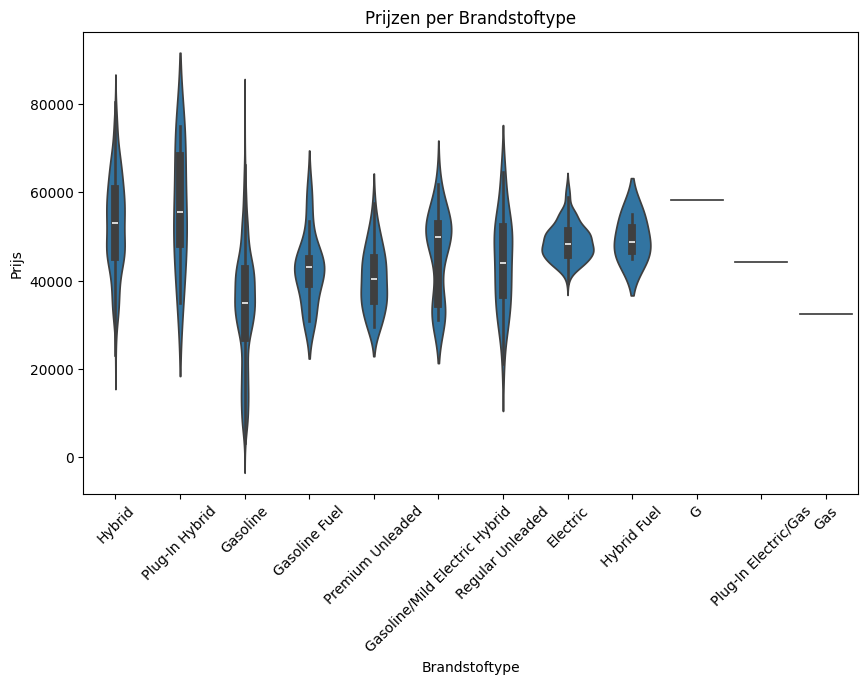

In [63]:
data_volvo = volvo_cars

# Maak een staafdiagram van de gemiddelde kosten per brandstoftype
avg_prices = volvo_cars.groupby('fuel_type')['price'].mean().reset_index()
plt.figure(figsize=(10, 6))
sns.barplot(x='fuel_type', y='price', data=avg_prices)
plt.title('Gemiddelde prijs per Brandstoftype')
plt.xlabel('Brandstoftype')
plt.ylabel('Gemiddelde Prijs')
plt.xticks(rotation=45)  # Roteren van x-labels voor leesbaarheid
plt.ylim(0, 100000)  # Y-limiet instellen
plt.show()

# Maak een stripplot van de kosten per brandstoftype
plt.figure(figsize=(10, 6))
sns.stripplot(x='fuel_type', y='price', data=data_volvo, jitter=True)
plt.title('Prijzen per Brandstoftype')
plt.xlabel('Brandstoftype')
plt.ylabel('Prijs')
plt.xticks(rotation=45)  # Roteren van x-labels voor leesbaarheid
plt.ylim(0, 100000)  # Y-limiet instellen
plt.show()


# Maak een boxplot van de kosten per brandstoftype
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=data_volvo)
plt.title('Prijzen per Brandstoftype')
plt.xlabel('Brandstoftype')
plt.ylabel('Prijs')
plt.xticks(rotation=45)  # Roteren van x-labels voor leesbaarheid
plt.ylim(0, 100000)  # Y-limiet instellen
plt.show()

# Maak een violinplot van de kosten per brandstoftype
plt.figure(figsize=(10, 6))
sns.violinplot(x='fuel_type', y='price', data=data_volvo)
plt.title('Prijzen per Brandstoftype')
plt.xlabel('Brandstoftype')
plt.ylabel('Prijs')
plt.xticks(rotation=45)  # Roteren van x-labels voor leesbaarheid
plt.show()

### Vraag 5:
Gegeven volgende boxplots van de prijs van elektrische & benzine wagens, zijn volgende uitspraken waar/onwaar/niet te besluiten & leg uit:

![alt text](image-2.png)

 - De spreiding op de prijs van elektrische wagens is groter dan die van benzinewagens.

 - Een wagen die meer dan 50 000 euro kost heeft een grotere kans om elektrisch te zijn dan benzine.

 - Een elektrische wagen heeft een grotere kans om meer dan 50 000 euro te kosten dan een benzine wagen.

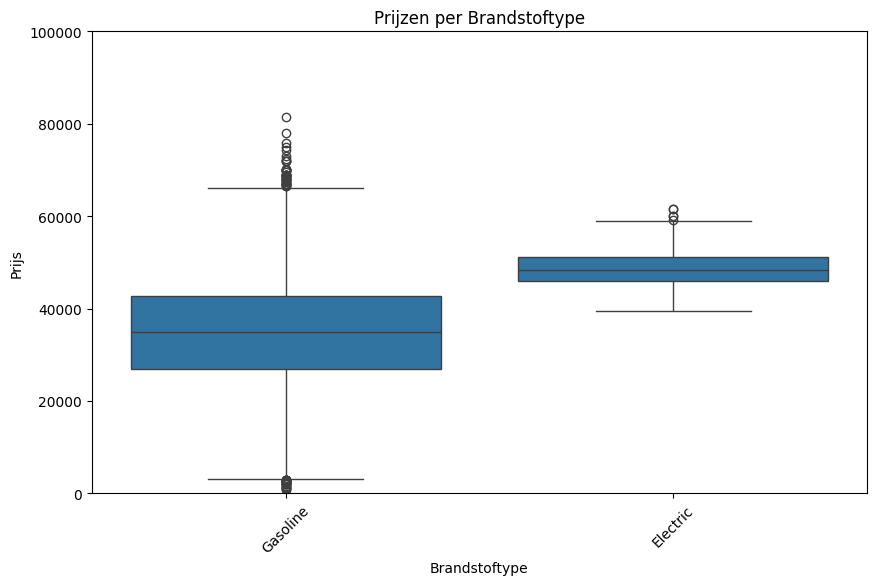

In [64]:
#Filter data naar Elektrisch en benzine
data_volvo = volvo_cars.loc[volvo_cars['fuel_type'].isin(['Electric', 'Gasoline'])]

# Maak een boxplot van de prijzen per brandstoftype
plt.figure(figsize=(10, 6))
sns.boxplot(x='fuel_type', y='price', data=data_volvo)
plt.title('Prijzen per Brandstoftype')
plt.xlabel('Brandstoftype')
plt.ylabel('Prijs')
plt.xticks(rotation=45)  # Roteren van x-labels voor leesbaarheid
plt.ylim(0, 100000)  # Y-limiet instellen
plt.show()


**Antwoord A:**

 - De spreiding op de prijs van elektrische wagens is groter dan die van benzinewagens:  
 
   Neen, de spreiding bij benzine (gasoline) wagens is veel hoger dan de prijs van elektrische wagens. Dit is duidleijk te zien aan de boxplot omdat de kwartielen bij elektrische autos veel kleiner zijn, dichter op elkaar liggen.  

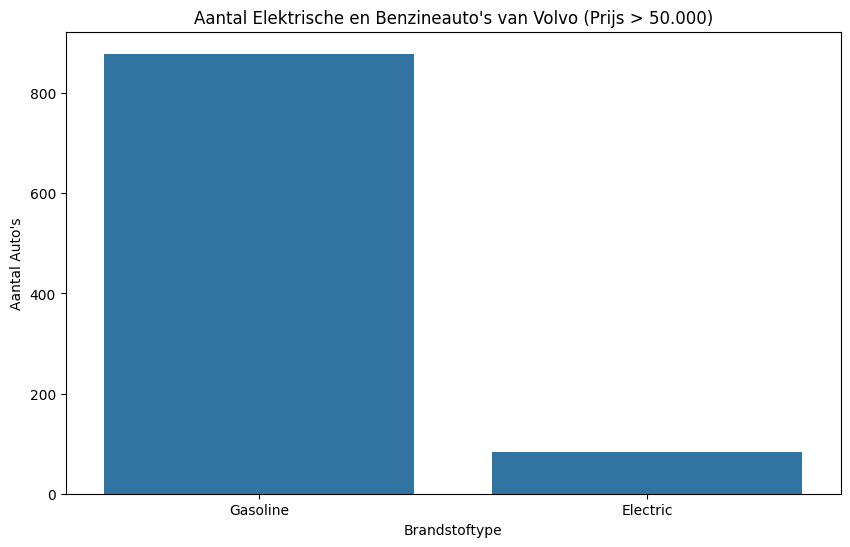

In [65]:

# Filter op brandstof en prijs
data_volvo = volvo_cars.loc[(volvo_cars['fuel_type'].isin(['Electric', 'Gasoline'])) & (volvo_cars['price'] > 50000)]
#Maak een staafdiagram
plt.figure(figsize=(10, 6))
sns.countplot(x='fuel_type', data=data_volvo)
plt.title('Aantal Elektrische en Benzineauto\'s van Volvo (Prijs > 50.000)')
plt.xlabel('Brandstoftype')
plt.ylabel('Aantal Auto\'s')
plt.show()

**Antwoord B:**
 - Een wagen die meer dan 50 000 euro kost heeft een grotere kans om elektrisch te zijn dan benzine.

    Neen, ondankt dat elektrische auto's duurder zijn dan gemiddeld, blijft de kans veel groter dat een auto van meer dan 50 000 euro op b enzine rijdt. Dit omdat er in absolute aantallen nog altijd veel meer benzine auto's worden gekocht/verkocht (zie de staafdiagram van deze wagens).

 

In [66]:
import pandas as pd

# Filter de gegevens van Volvo-auto's op elektrische en benzinebrandstoftypes en maak een kopie
data_volvo = volvo_cars.loc[volvo_cars['fuel_type'].isin(['Electric', 'Gasoline'])].copy()

# Voeg een extra kolom toe voor onderscheid op de prijs van 50.000
data_volvo.loc[:, 'Price Category'] = pd.cut(data_volvo['price'], bins=[0, 50000, float('inf')], labels=['<50000', '>=50000'])

# Groepeer op brandstoftype en prijscategorie en tel het aantal auto's
grouped_data = data_volvo.groupby(['fuel_type', 'Price Category'], observed=False).size().reset_index(name='Count')

# Bereken het totale aantal auto's per brandstoftype
total_counts = data_volvo.groupby('fuel_type').size().reset_index(name='Total Count')

# Voeg de totale aantallen toe aan de gegroepeerde data
grouped_data = grouped_data.merge(total_counts, on='fuel_type')

# Bereken het percentage auto's per prijscategorie binnen elk brandstoftype
grouped_data['Percentage'] = (grouped_data['Count'] / grouped_data['Total Count']) * 100

# Toon de gegroepeerde gegevens met percentages
grouped_data


,fuel_type,Price Category,Count,Total Count,Percentage
0,Electric,<50000,169,253,66.798419
1,Electric,>=50000,84,253,33.201581
2,Gasoline,<50000,8102,8981,90.212671
3,Gasoline,>=50000,879,8981,9.787329


**Antwoord C:**  

 - Een elektrische wagen heeft een grotere kans om meer dan 50 000 euro te kosten dan een benzine wagen:  
 
    Dat klopt. Een elektrische wegen heeft 33 % kans om een prijs te hebben die hoger ligt dan 50 000 euro. Dit terwijl een benzine aangedreven auto slecht ene kans heeft van 10 % om meer dan 50 000 euro te kosten. Dit kunnen we aflezen uit bovenstaande tabel.
 

### Vraag 6:
Maak een visualizatie om het verband tussen mileage & price te tonen?

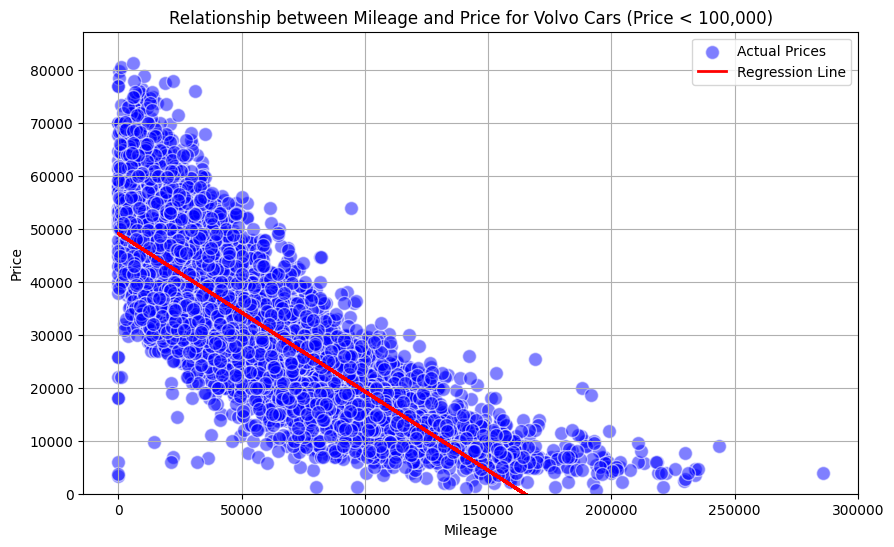

In [67]:
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

# Filter the data of Volvo cars with price under 100,000 and mileage under 400,000
data_volvo = volvo_cars.loc[(volvo_cars['price'] < 100000) & (volvo_cars['mileage'] < 400000)]

# Extract the features (mileage) and target variable (price)
X = data_volvo[['mileage']]
y = data_volvo['price']

# Initialize and fit the linear regression model
model = LinearRegression()
model.fit(X, y)

# Predict the prices using the model
predicted_prices = model.predict(X)

# Plot the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data_volvo['mileage'], data_volvo['price'], alpha=0.5, c='blue', edgecolors='w', s=100, label='Actual Prices')

# Plot the regression line
plt.plot(X, predicted_prices, color='red', linewidth=2, label='Regression Line')

# Add titles and labels
plt.title('Relationship between Mileage and Price for Volvo Cars (Price < 100,000)')
plt.xlabel('Mileage')
plt.ylabel('Price')

# Set the lower limit of the y-axis to 0
plt.ylim(bottom=0)

# Add legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()



### Vraag 7:
Volgens deze data is de gemiddelde prijs van $2^e$ hands elektrische Volvo’s 48 000 euro; als we veronderstellen dat onze dataset representatief is voor alle 2de hands volvo’s, hoe kan je de accuraatheid van deze schatting nagaan?

In [68]:
# Bereken de standaardfout van het gemiddelde
standaardfout_gemiddelde = volvo_cars['price'].std() / np.sqrt(len(volvo_cars))

# Kies het gewenste betrouwbaarheidsniveau (bijvoorbeeld 95%)
betrouwbaarheidsniveau = 0.95

# Bereken de z-score op basis van het betrouwbaarheidsniveau
z_score = t.ppf((1 + betrouwbaarheidsniveau) / 2, len(volvo_cars) - 1)

# Bereken het betrouwbaarheidsinterval
gemiddelde_prijs = int(volvo_cars['price'].mean())
betrouwbaarheidsinterval = (int(gemiddelde_prijs - z_score * standaardfout_gemiddelde),
                            int(gemiddelde_prijs + z_score * standaardfout_gemiddelde))

print("De gemiddelde prijs van een tweedehands Volvo is:", gemiddelde_prijs)
print("Het 95 procent betrouwbaarheidsinterval voor het gemiddelde is:", betrouwbaarheidsinterval)


De gemiddelde prijs van een tweedehands Volvo is: 35799
Het 95 procent betrouwbaarheidsinterval voor het gemiddelde is: (35525, 36072)
